# Examen : Algorithms in Machine Learning

**Léa Berthomier**

On s'interesse ici à des données médicales.


## Lecture, extraction et visualisation  des données

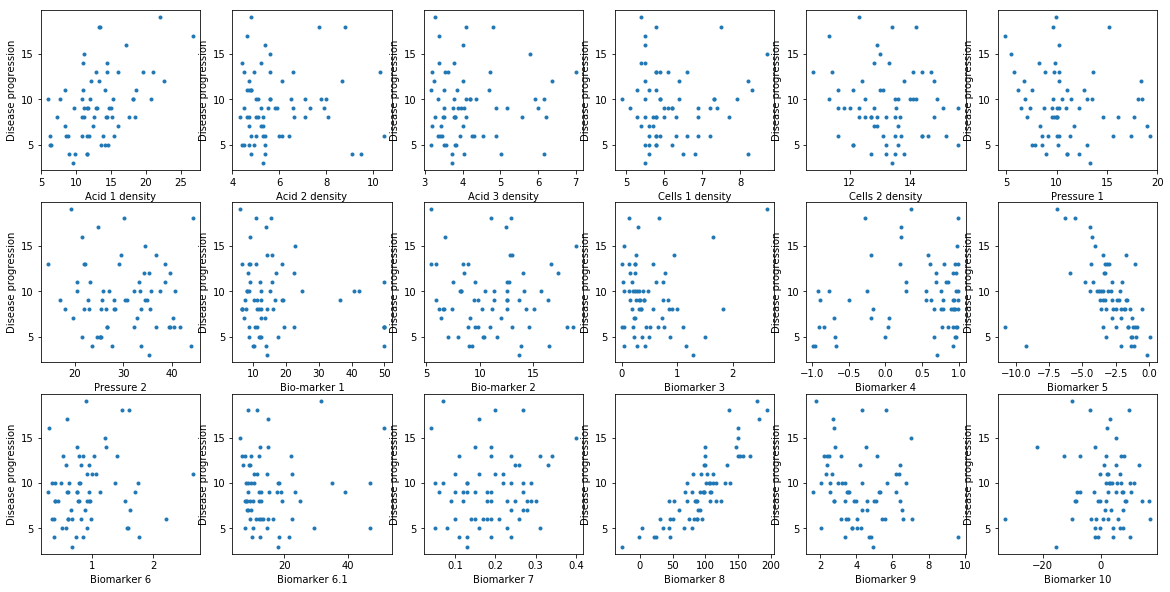

In [13]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

dataframe=pandas.read_csv("./MedicalData1.csv",sep=';',decimal=b',')

listColNames=list(dataframe.columns)


XY=dataframe.values
ColNb_Y=listColNames.index('Disease progression')


Y=XY[:,ColNb_Y].reshape((XY.shape[0],1))   #reshape is to make sure that Y is a column vector
X = np.delete(XY, ColNb_Y, 1)

X_scaled = preprocessing.scale(X)

listColNames.pop(ColNb_Y)     #to make it contains the column names of X only

plt.figure(figsize = (20,10))

for Col in range(len(listColNames)):
    plt.subplot(3, 6, Col+1)
    plt.plot(X[:,Col],Y[:],'.')
    plt.xlabel(listColNames[Col])
    plt.ylabel('Disease progression')

plt.show()

## Question 1

*Observez les donnees unes par unes. Est-ce que vous identifiez visuellement des liens entre certaines variables et la variable 'Disease progression'. Si oui, lesquels ?*

Visuellement, on peut penser qu'il y a une correlation linéaire positive entre Disease Progression et Acid 1 Density et Biomarker 8. Il pourrait aussi y avoir une corrélation négative entre Disease Progression et Biomarker 5. En revanche pour les autres variables, les points sont trop dispersés pour identifier visuellement une relation avec Disease Progression.

## Question 2

*On se demande si il est possible de predire le niveau de 'Disease progression' à partir de de la variable 'Acid 1 density'.*

### QUESTION 2.1 : 
*Effectuez une regression lineaire simple entre ces deux variables et predisez ensuite les valeurs de 'Disease progression' a l'aide de 'Acid 1 density'. Vous pourrez evaluer la qualité des predictions a l'aide du coefficient de determination R2.*

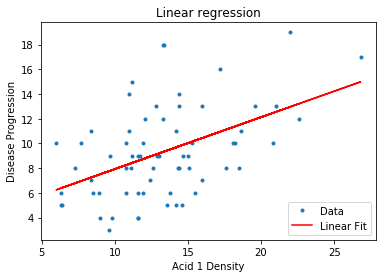

Le coefficient de détermination R² vaut : 0.228


In [2]:
from sklearn.linear_model import LinearRegression

acid = X[:, 0]

# Linear Regression
lr = LinearRegression()
lr.fit(acid[:, np.newaxis], Y[:])

# Predict Disease Progression with the linear regression
prediction = lr.predict(acid[:, np.newaxis])

# Plot the data and regression
fig = plt.figure()
plt.plot(acid, Y, '.')
plt.plot(acid, prediction, 'r-')
plt.xlabel('Acid 1 Density')
plt.ylabel('Disease Progression')
plt.legend(('Data', 'Linear Fit'), loc='lower right')
plt.title('Linear regression')
plt.show()

# Compute  r²
r_2 = lr.score(acid[:, np.newaxis], Y[:])
print("Le coefficient de détermination R² vaut : {0}".format(round(r_2, 3)))

On obtient un coefficient de détermination de 0.228, ce qui est assez faible : la corrélation linéaire n'est pas de bonne qualité.

### QUESTION 2.2 : 
*Evaluez la stabilite des predictions a l'aide d'une methode de validation croisee de type 4-folds.*

In [3]:
from sklearn.model_selection import KFold

r2_list = []

kf = KFold(n_splits=4, shuffle = True) # Shuffle the split
for train, test in kf.split(acid):
    X_train=acid[train]
    y_train=Y[train]
    X_test=acid[test]
    y_test=Y[test]
    
    lr.fit(X_train[:, np.newaxis], y_train)
  
    y_pred = lr.predict(X_test[:, np.newaxis])
    r_2 = lr.score(X_test[:, np.newaxis], y_test)
    r2_list.append(r_2)
    
print("Coefficients de détermination : {}".format([round(x,3) for x in r2_list]))
print("Moyenne des 4 coefficients de détermination : {0}".format(round(sum(r2_list)/4, 3)))

Coefficients de détermination : [0.039, 0.203, 0.149, 0.332]
Moyenne des 4 coefficients de détermination : 0.18


Les prédictions sont très instables : le coefficient de détermination varie fortement selon le découpage 4-Fold.


### QUESTION 2.3 : 
*Auriez-vous eu de meilleurs resultats en predisant 'Disease progression' a l'aide de la variable 'Biomarker 8' ou 'Pressure 1'?*

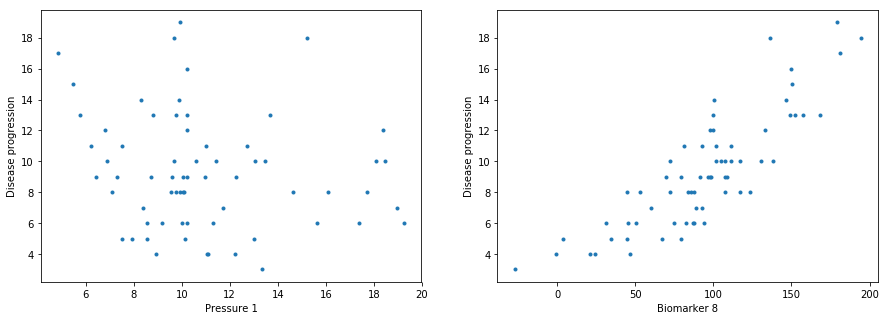

In [4]:
plt.figure(figsize = (15,5))

plt.subplot(1, 2, 1)
plt.plot(X[:,5],Y[:],'.')
plt.xlabel(listColNames[5])
plt.ylabel('Disease progression')

plt.subplot(1, 2, 2)
plt.plot(X[:,15],Y[:],'.')
plt.xlabel(listColNames[15])
plt.ylabel('Disease progression')

plt.show()

A la vue des graphiques, on peut penser qu'une régression linéaire donnerait de meilleurs résultats sur Biomarker 8 mais pas sur Pressure 1. Pour Biomarker 8, il semble y avoir une fort corrélation positive, mais pour Pressure 1, les points sont dispersés sur l'ensemble de l'espace, sans corrélation apparente.

### QUESTION 2.4 : 
*Peut-on enfin dire si on observe une relation significative entre 'Disease progression' et (independament) 'Acid 1 density' ou 'Biomarker 8' ou 'Pressure 1'? On peut le valider en testant si les coefficients des pentes obtenues entre 'Disease progression' et chacune de ses trois variables par regression lineaire simples sont significativement differentes de 0.*

Traçons les trois regressions linéaires et observons les coefficients obtenus. On prendra les données mises à l'échelle (réduites) pour pouvoir comparer les coefficients des pentes. 

On effectuera ensuite un test statistique de Student pour tester l'hypothèse de nullité des coefficients des pentes et vérifier si nous pouvons la rejeter. Nous allons donc faire l'hypothèse que $\beta_1 = 0$ puis calculer la statistique $\frac{b_1 - \beta_1}{\sqrt{\frac{s^2}{(n-1) s_x^2}}}$ qui suit une loi de Student à (n-2) degrés de liberté. La p-value du test statistique sur cette variable nous permettra de rejeter ou non l'hypothèse.

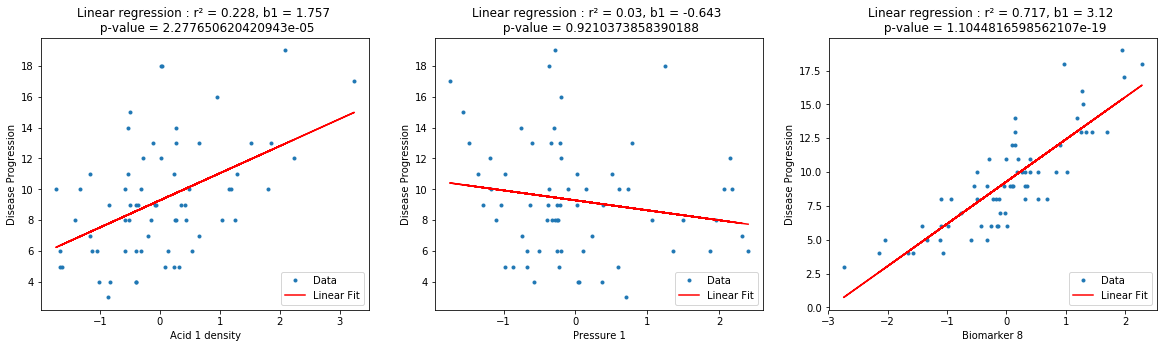

In [5]:
from scipy import stats

features = [0,5,15]
n = len(X_scaled)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

plt.figure(figsize = (20,5))

for i in range(len(features)) :
    feature = X_scaled[:, features[i]]
    lr.fit(feature[:, np.newaxis], Y[:])
    prediction = lr.predict(feature[:, np.newaxis])
    r_2 = lr.score(feature[:, np.newaxis], Y[:])
    
    # Calcul de la statistique qui suit une loi de Student à (n-2) degrés de liberté
    s2 = (sum((Y - prediction)**2) / (n-1))[0]
    X_mean = np.mean(feature)
    sx2 = sum((feature - X_mean)**2) / (n-1)
    b1 = lr.coef_[0][0]
    stat = b1 / ((s2 / sx2 / (n-1))**0.5)
    
    p = stats.t.sf(stat, n-2) #p-value
    
    plt.subplot(1, 3, i+1)
    plt.plot(feature,Y[:],'.')
    plt.plot(feature, prediction, 'r-')
    plt.xlabel(listColNames[features[i]])
    plt.ylabel('Disease Progression')
    plt.legend(('Data', 'Linear Fit'), loc='lower right')
    plt.title('Linear regression : r² = {0}, b1 = {1} \n p-value = {2}'.format(round(r_2, 3), round(lr.coef_[0,0], 3), p))
plt.show()

La relation entre Disease Progression et Biomarker 8 est significative : l'hypothèse de nullité du coefficient de la pente a été rejetée par le test avec une p-value inférieure à 0.05. En revanche pour Pressure 1, on ne peut pas rejeter l'hypothèse car la p-value est très grande (0.9). On ne peut donc pas conclure pour Pressure 1.

## QUESTION 3 :  
*On s'interesse maintenant au lien entre la variable 'Disease progression' et 'Biomarker 5'. On peut remarquer que ces donnees contiennent deux valeurs aberrantes.*

### QUESTION 3.1 : 
*Quelles sont les valeurs aberrantes et quel va etre leur impact lors de l'estimation d'une relation lineaire entre ces deux variables ?*

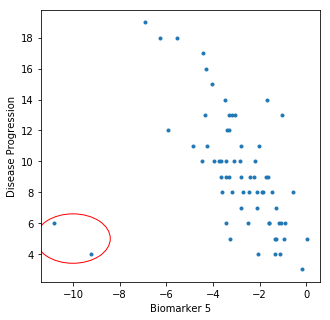

In [6]:
plt.figure(figsize = (5,5))
ax = plt.axes()

plt.plot(X[:,11],Y[:],'.')
plt.xlabel(listColNames[11])
plt.ylabel('Disease Progression')
ax.add_artist(plt.Circle((-10,5), 1.6, color='r', fill=False))

plt.show()

On constate qu'il y a deux valeurs aberrantes pour des valeurs de Biomarker 5 inférieures à -8. Ces valeurs risquent de biaiser le calcul des coefficients de la regression linéaire.

### QUESTION 3.2 : 
*Definissez une procedure de detection automatique de ces variables basee sur la distance de Cook.*

Nous allons calculer la matrice Hat pour le jeu de données Biomarker 5, puis calculer la distance de Cook de chaque échantillon. Sachant que nous avons deux données abérrantes, nous chercherons ensuite l'index des deux échantillons avec les plus grandes distances de Cook.


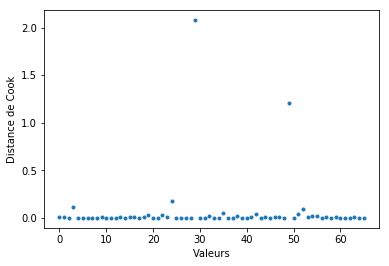

Les indices des deux données aberrantes sont : [29, 48]


In [7]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
biomarker = X[:,11]
N = len(biomarker)

# Compute the Hat matrix
hat = [[0 for j in range(N)] for i in range(N)]
for i in range(N):
    X_i = np.delete(biomarker,i)
    Y_i = np.delete(Y,i)
    lr.fit(X_i[:,np.newaxis], Y_i)
    for j in range(N):
        hat[i][j] = lr.predict(biomarker[j])[0]

# Compute the Cook distance for each value
lr.fit(biomarker[:,np.newaxis],Y)
y_pred = lr.predict(biomarker[:, np.newaxis])
s_2 = sum([(Y[j]-y_pred[j])**2 for j in range(N)])/(N-2)
cook = [(sum([(hat[i][j] - y_pred[j])**2 for j in range(N)]/(2*s_2)))[0] for i in range(N)]

plt.plot(cook, '.')
plt.xlabel('Valeurs')
plt.ylabel('Distance de Cook')
plt.show()

# Find the index
nb_aberrant_values = 2
id_val = []
for i in range(nb_aberrant_values) :
    index = cook.index(max(cook))
    id_val.append(index)
    cook.pop(index)
print("Les indices des deux données aberrantes sont : {}".format(id_val))
    


On peut donc déterminer quels sont les échantillons abérrants pour pouvoir les traiter ensuite si besoin.

Si on ne connaissait pas le nombre de valeurs abérrantes, on pourrait aussi fixer un seuil de détection pour la distance de Cook.

### QUESTION 3.3 : 
*Pourriez vous plus simplement detecter ces observations aberrantes a l'aide des residus ? Si oui, decrivez comment, sans necessairement coder la solution.*

On pourrait considérer que les résidus suivent une loi de Student à (n − 3) degrés de liberté. Dans ce cas, il serait possible d'utiliser un test d'hypothèses pour vérifier l'existence de valeurs abérrantes. Pour détecter plusieurs observations abérrantes simultanément, on pourrait également utiliser l'inégalité de Bonferroni.

### QUESTION 3.4 : 
*Comment traiteriez-vous les donnees aberrantes dans le contexte de la regression lineaire entre 'Disease progression' et 'Biomarker 5' pour estimer un lien pertinent entre ces deux variables.*

Dans le cas présent et dans le but de faire une regression linéaire, on peut considérer que nous avons suffisamment d'échantillons (66) pour décider que ces deux observations sont abérrantes (dues pas exemple à des erreurs de manipulation lors de la récolte des échantillons) et que nous pouvons nous en passer sans risque pour la suite de l'analyse. Nous pouvons donc les supprimer du jeu de données.

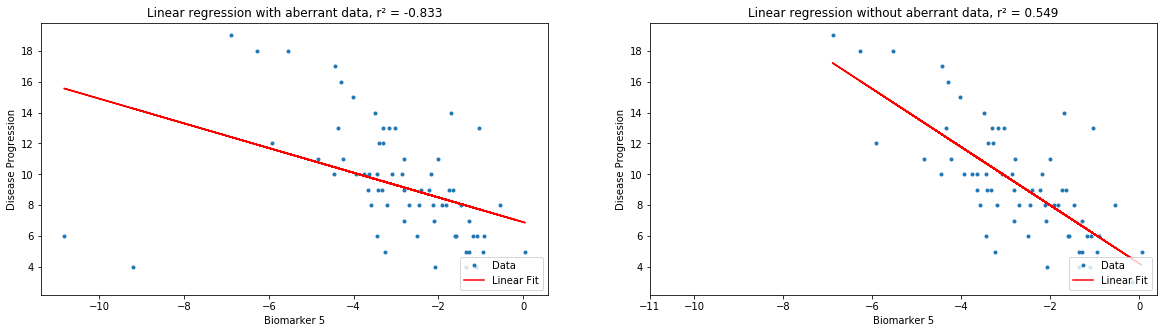

In [8]:
plt.figure(figsize = (20,5))
biomarker_processed = np.delete(biomarker,29)
biomarker_processed = np.delete(biomarker_processed,48)
Y_processed = np.delete(Y,29)
Y_processed = np.delete(Y_processed,48)

lr.fit(biomarker[:, np.newaxis], Y[:])
prediction = lr.predict(biomarker[:, np.newaxis])
r_2 = lr.score(feature[:, np.newaxis], Y[:])

plt.subplot(1, 2, 1)
plt.plot(biomarker,Y[:],'.')
plt.plot(biomarker, prediction, 'r-')
plt.xlabel(listColNames[11])
plt.ylabel('Disease Progression')
plt.legend(('Data', 'Linear Fit'), loc='lower right')
plt.title('Linear regression with aberrant data, r² = {0}'.format(round(r_2, 3)))

lr.fit(biomarker_processed[:, np.newaxis], Y_processed[:])
prediction = lr.predict(biomarker_processed[:, np.newaxis])
r_2 = lr.score(biomarker_processed[:, np.newaxis], Y_processed[:])

plt.subplot(1, 2, 2)
plt.plot(biomarker_processed,Y_processed[:],'.')
plt.plot(biomarker_processed, prediction, 'r-')
plt.xlabel(listColNames[11])
plt.xticks([-11, -10, -8, -6, -4, -2, 0])
plt.ylabel('Disease Progression')
plt.legend(('Data', 'Linear Fit'), loc='lower right')
plt.title('Linear regression without aberrant data, r² = {0}'.format(round(r_2, 3)))

plt.show()

## QUESTION 4 :   
*Une fois les observations aberrantes de 'Biomarker 5' traitees, on souhaite selectionner les variables de 'X' qui permettent de prédire au mieux 'Disease progression' a l'aide de la regression multiple regularisee.*

### QUESTION 4.1 : 
*Expliquez pourquoi vous effecturez cette procedure sur 'X_scaled' plutot que 'X' ?*

Pour sélectionner les variables qui permettent d'expliquer Disease Progression (Y), nous allons modéliser Y sous la forme :
$$ Y = \beta_0 X_0 + \beta_1 X_1 + ... + \beta_p X_p $$
Nous allons ensuite effectuer une regresison linéaire multiple avec ce modèle puis sélectionner les variables $X_p$ telles que $\beta_p$ soit significativement différent de 0.

Si nous utilisons directement X, la valeur de $\beta_p$ sera inversement proportionnelle à la moyenne de $X_p$ : les valeurs de Biomarker 4 sont comprises entre -1 et 1, il aura donc un grand $\beta$ même s'il n'explique pas Y. En revanche, les valeurs de Biomarker 8 sont comprises entre 0 et 200, donc même s'il explique bien Y, sa valeur de $\beta$ sera petite par rapport à celle de Biomarker 4.

Il nous faut donc utiliser X_scaled si nous voulons être capable de compararer les différents $\beta$ et choisir les variables explicatives.


### QUESTION 4.2 : 
*Expliquez pourquoi vous regulariserez les coefficients estimés avec une regularisation de type LASSO plutot que RIDGE ?*

La regression de Ridge nous fournirait des valeurs de $\beta$ non nulles pour toutes les variables $X_p$, il serait donc difficile d'interpréter les résultats et de sélectionner un petit nombre de variables explicatives.

La regression  LASSO utilise une méthode de régularisation grâce à la norme $L_1$ au lieu de la norme $L_2$, qui force le plus grand nombre de $\beta$ possible à 0. Les résutats sont donc plus simples à interpréter : il suffit de choisir les $\beta$ non nuls. En revanche, il nous faudra choisir le paramètre $\lambda$ de pénalisation : si $\lambda$ vaut 0, on retrouve la regression de Ridge et toutes les valeurs sont non nulles; si $\lambda$ tend vers $+\infty$, tous les $\beta$ sont nuls.

### QUESTION 4.3 : 
*Codez la procedure de selection des variables optimales en parametrant a la main le poids entre la qualite de prediction et le niveau de regularisation*

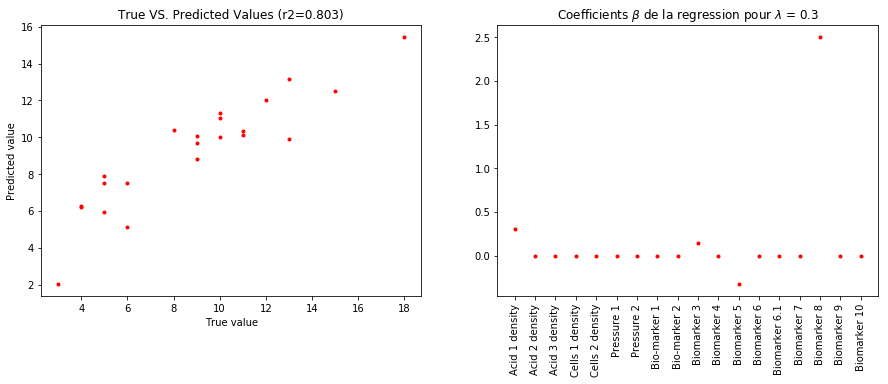

In [9]:
# Divide the set in two parts to avoid over-fitting
thresh = 2* len(X_scaled) // 3
X_train = X_scaled[:thresh]
Y_train = Y[:thresh]
X_test = X_scaled[thresh:]
Y_test = Y[thresh:]

# Linear Regression with LASSO regression
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

alpha = 0.3
lasso_regressor = Lasso(alpha=alpha)
lasso_regressor.fit(X_train, Y_train)
Y_pred_lasso = lasso_regressor.predict(X_test)
r2_score_lasso = lasso_regressor.score(X_test, Y_test)

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(Y_test, Y_pred_lasso, 'r.')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('True VS. Predicted Values (r2='+str(round(r2_score_lasso,3))+')')

plt.subplot(1,2,2)
plt.plot(listColNames, lasso_regressor.coef_, 'r.')
plt.xticks(rotation=90)
plt.title('Coefficients $\\beta$ de la regression pour $\\lambda$ = {0}'.format(alpha))
plt.show()


### QUESTION 4.4 : 

*Codez la procedure automatique de parametrisation de ce poids, de sorte a ce qu'un maximum de trois variables soit typiquement selectionné et que la qualité de prediction soit optimale. Une procédure de validation croisée de type leave-one-out sera idealement utilisee. La selection des variables est-elle stable ?*

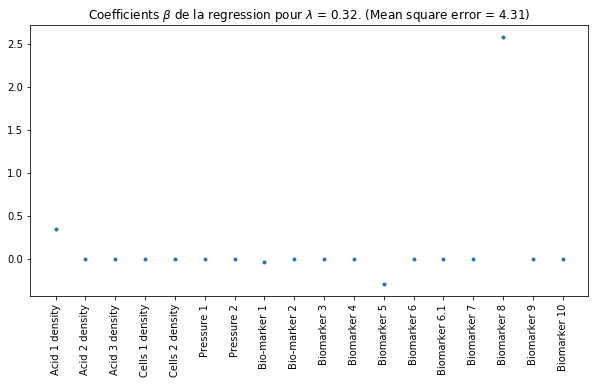

In [10]:
# On fixe un seuil de detection des Betas à 0.2 (ils sont alors significativement différents de 0)
detection_threshold = 0.2 
results = []

# On parcourt les valeurs de alpha entre 0 et 1
for alpha in np.linspace(0.001,1,20):
    
    error_list = []
    
    kf = KFold(n_splits=len(X_scaled)) # Leave One Out

    for train, test in kf.split(acid):
        X_train = X_scaled[train]
        Y_train = Y[train]
        X_test = X_scaled[test]
        Y_test = Y[test]
        
        lasso_regressor = Lasso(alpha=alpha)
        lasso_regressor.fit(X_train, Y_train)
        Y_pred_lasso = lasso_regressor.predict(X_test)
        error_list.append(((Y_pred_lasso[0] - Y_test[0])**2)[0]) # Mean square error
        
    error_lasso = sum(error_list)/len(error_list)    
    coef_detected = [round(c,2) for c in lasso_regressor.coef_ if abs(c)>=detection_threshold]
    
    # On sélectionne les valeurs de alhpa qui génèrent moins de 3 coefficients beta significatifs
    if len(coef_detected) <= 3 :
        results.append((alpha, error_lasso, lasso_regressor.coef_))

# On choisit la solution qui a la plus faible erreur
solution = results[0]
for a, err, coefs in results :
    if err < solution[1]:
        solution = (a, err, coefs)    
    
plt.figure(figsize = (10,5))
plt.plot(listColNames, solution[2], '.')
plt.xticks(rotation=90)
plt.title('Coefficients $\\beta$ de la regression pour $\\lambda$ = {0}. (Mean square error = {1})'.format(round(solution[0],2), round(solution[1],2)))
plt.show()

En changeant le découpage de K-fold, on obtient toujours les mêmes variables sélectionnées : la sélection est donc stable.

## QUESTION 5 :   
*On s'interesse enfin au fichier 'MedicalData2.csv' et non 'MedicalData1.csv' qui contient une colonne qualitative supplementaire 'Pathology type'.*

### QUESTION 5.1 : 
*Quelles sont les differences entre les structures du fichier 'MedicalData2.csv' et du fichier 'MedicalData1.csv' en plus de cette colonne supplementaire.*

On peut constater que le fichier 1 utilise la notation française (virgules pour les décimales et point-virgules pour séparer les valeurs) tandis que le fichier 2 utilise la notation anglaise (point pour les décimales et virgules pour séparer les valeurs.

### QUESTION 5.2 : 
*Est-ce qu'une variable semble bien expliquer la classe de 'Pathology type'. Quelle demarche vous semble la plus pertinente pour identifer cette variable ?* 

Pour commencer, observons les données par rapport à la variable *Pathology type*.

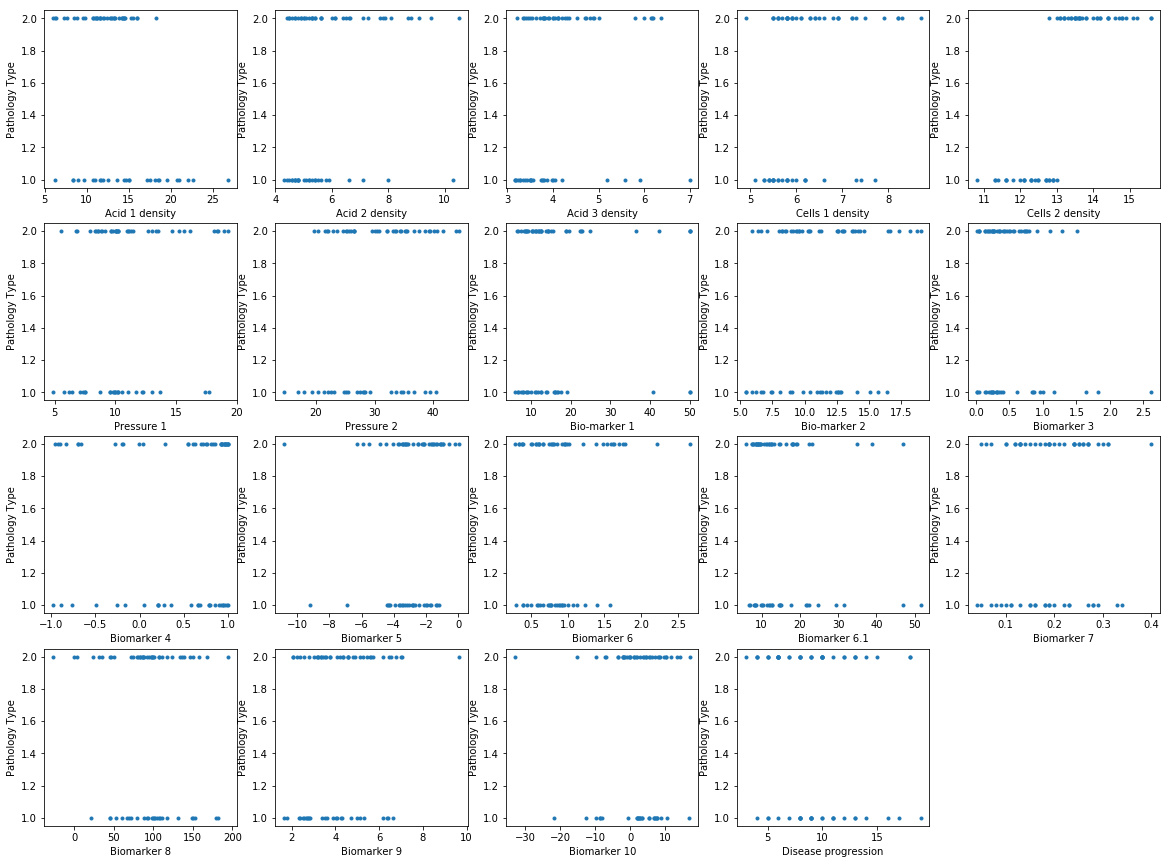

In [11]:
dataframe=pandas.read_csv("./MedicalData2.csv",sep=',',decimal=b'.')

listColNames2=list(dataframe.columns)


XY2=dataframe.values
ColNb_Y2=listColNames2.index('Pathology type')


Y2=XY2[:,ColNb_Y2].reshape((XY2.shape[0],1))   #reshape is to make sure that Y is a column vector
X2 = np.delete(XY2, ColNb_Y2, 1)

X2_scaled = preprocessing.scale(X2)

listColNames2.pop(ColNb_Y2)     #to make it contains the column names of X only

plt.figure(figsize = (20,15))

for Col in range(len(listColNames2)):
    plt.subplot(4, 5, Col+1)
    plt.plot(X2[:,Col],Y2[:],'.')
    plt.xlabel(listColNames2[Col])
    plt.ylabel('Pathology Type')

plt.show()

A l'aide des graphiques, on peut constater que la variable *Cells 2 density* semble expliquer le mieux la variable *Pathology Type*.

Nous avons alors plusieurs possibilités : 

- Vérifier cette hypothèse grâce à un test de Fisher sur l'égalité des moyennes : On suppose que les moyennes des deux groupes crées par *Pathology type* sont égales et on cherche à invalider cette hypothèse par le test.

- Faire une regression logistique sur l'ensemble des données et selectionner les variables dont les coefficients sont significativement différents de 0.

- Faire une regression logistique sur chacune des variables et sélectionner celle qui a le meilleur coefficient de détermination.

Pour la suite nous utiliserons la deuxième méthode.


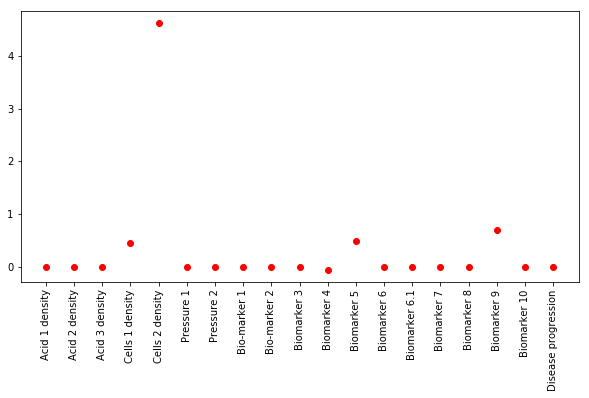

In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l1')
model.fit(X2_scaled, Y2[:, 0])
#On fit le model sur toutes les variables, pour qu'elles expliquent le traitement
#(=on cherche une preuve que le traitement a été inoculé)
#on ajoute une penalite L1 LASSO   pour que peu de Betas ne soient pas nuls
betas = model.coef_[0]  # les betas
Y2_pred = model.predict(X2_scaled)

plt.figure(figsize = (10,5))
plt.plot(listColNames2, betas, 'ro')
plt.xticks(rotation = 90)

plt.show()

*Cells 2 Density* est bien la variable avec le plus grand coefficient, c'est donc celle qui explique le mieux *Pathology Type*.